In [1]:
%%capture
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot([0,1],[1,0])
from neuronunit.optimisation.make_sim_tests import test_all_objective_test
#from neuronunit.optimisation.optimization_management import test_all_objective_test

import numpy as np
from IPython.display import display, HTML
from neuronunit.plottools import plot_score_history1
from neuronunit.optimisation.optimization_management import check_binary_match, dtc_to_rheo
import pandas as pd
from neuronunit.optimisation.optimization_management import TSD
from neuronunit.tests.fi import RheobaseTestP
from neuronunit.optimisation.optimization_management import inject_and_plot_model, TSD

from neuronunit.optimisation.model_parameters import MODEL_PARAMS
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plot_defaults = mpl.rcParamsDefault


# Generate Simulated Data with A Hodgkin Huxley model 
Then optimize with an adaptive exponential.
Then optimize an adaptive exponential model to fit it.

# Simulated Data 
and select model parameters that are free to vary

In [2]:
import warnings
warnings.filterwarnings("ignore")
model_type="HH"

params = MODEL_PARAMS[model_type];
fps = params.keys()#['C','peak_v','b']
sim_tests, OM, target = test_all_objective_test(fps,model_type=model_type)

rtp = RheobaseTestP(sim_tests["RheobaseTest"].observation)
sim_tests["RheobaseTest"] = rtp
sim_tests = TSD(sim_tests)

Random simulated data tests made


In [3]:
target_model = target.dtc_to_model()

In [4]:
%%time 
pred = rtp.generate_prediction(target_model)

CPU times: user 94 ms, sys: 44.1 ms, total: 138 ms
Wall time: 623 ms


In [5]:
%%time
pred = sim_tests["RheobaseTest"].generate_prediction(target_model)

CPU times: user 280 ms, sys: 56 ms, total: 336 ms
Wall time: 999 ms


# Meta Parameters

In [6]:
MU = 8
NGEN = 12

<Figure size 640x480 with 0 Axes>

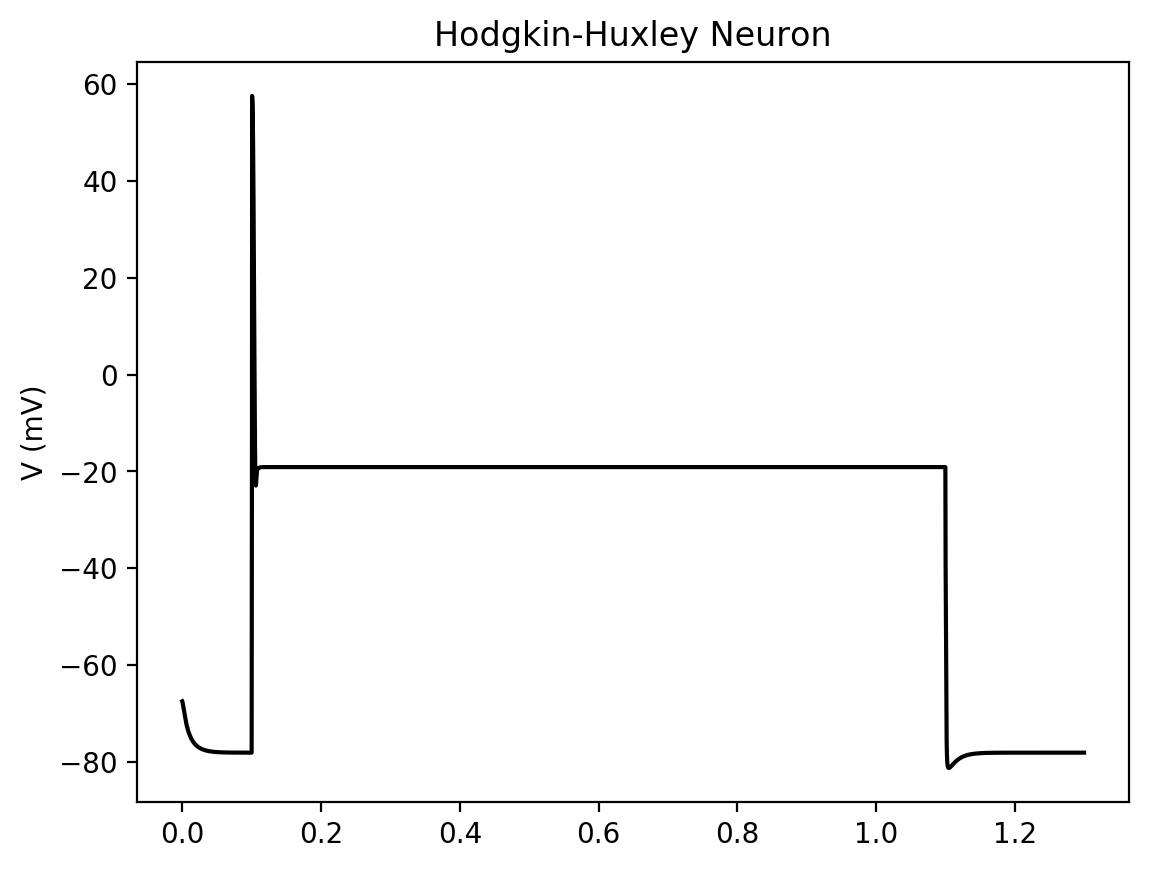

In [7]:

_,plt = inject_and_plot_model(target)
plt.show()

In [8]:
model_type="ADEXP"
params = MODEL_PARAMS[model_type];
fps = params.keys()
results = sim_tests.optimize(backend=model_type,\
        protocol={'allen': False, 'elephant': True},\
            MU=MU,NGEN=NGEN,plot=True,free_parameters=fps)

warning please add whether or not model should be scored on rheobase to protocol


Assembler messages:
Fatal error: can't create /home/russell/.cython/brian_extensions/home/russell/.cython/brian_extensions/_cython_magic_6b6f9fe4228d3b92d660c5581c069d99.o: No such file or directory
GA Generation Progress: 100%|██████████| 11/11 [17:59<00:00, 98.15s/it] 


In [9]:
results['pf'][0]
sim_tests.ga_out['td']
OM.td = results['td']
OM.backend = "ADEXP"
results['pf'][0].dtc = OM.update_dtc_pop([results['pf'][0]])[0]
results['hof'][0].dtc = OM.update_dtc_pop([results['hof'][0]])[0]


In [10]:

opt = results['pf'][0].dtc
hof = results['hof'][0].dtc
opt = results['pf'][0].dtc
opt = dtc_to_rheo(opt)
print(opt.rheobase)

304.66472303206996 pA


In [53]:
from neuronunit.tests.fi import RheobaseTest
opt.tests[0] = RheobaseTest(sim_tests["RheobaseTest"].observation)
sim_tests["RheobaseTest"] = RheobaseTest(sim_tests["RheobaseTest"].observation)
sim_tests.pop("RheobaseTestP",None)


# Analyse Results

In [30]:

opt.self_evaluate()


In [51]:
opt.get_agreement()


In [52]:
display(opt.agreement)


,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest,total
observations,112.5 pA,0.005106779201764274 ms,-78.10241997427573 mV,11296782291.03926 kg*m**2/(s**3*A**2),4.520560873174506e-16 s**4*A**2/(kg*m**2),0.0050375 s,134.3073017718617 mV,-76.76849116373268 mV,NaN
predictions,303.1402587890625 pA,1.533115489880656 ms,-105.0 mV,235323560.51434103 kg*m**2/(s**3*A**2),6.514925605110523e-12 s**4*A**2/(kg*m**2),0.001 s,42.13217274021965 mV,-42.027172740219655 mV,NaN
scores,1.33416,149.6,10.1705,142.5,7205,0.373083,0.312678,0.197246,30653.337925


In [31]:
opt.SA

RheobaseTest                         1.334155
TimeConstantTest                   149.600000
RestingPotentialTest                10.170472
InputResistanceTest                142.500000
CapacitanceTest                   7205.000000
InjectedCurrentAPWidthTest           0.373083
InjectedCurrentAPAmplitudeTest       0.312678
InjectedCurrentAPThresholdTest       0.197246
dtype: float64

# Can't look at evolution History yet

<Figure size 640x480 with 0 Axes>

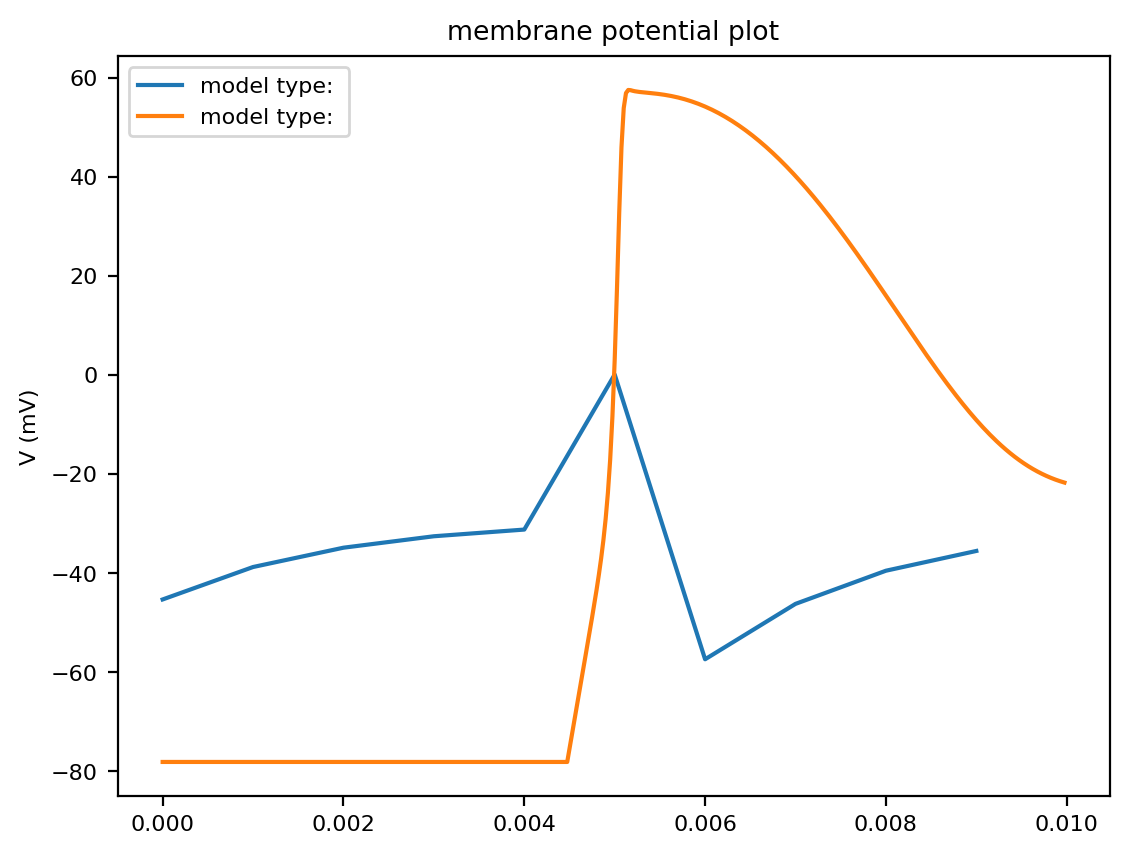

In [23]:
model = target.dtc_to_model()
check_binary_match(opt,target,snippets=True)
target = OM.format_test(target)
simulated_data_tests = target.tests

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

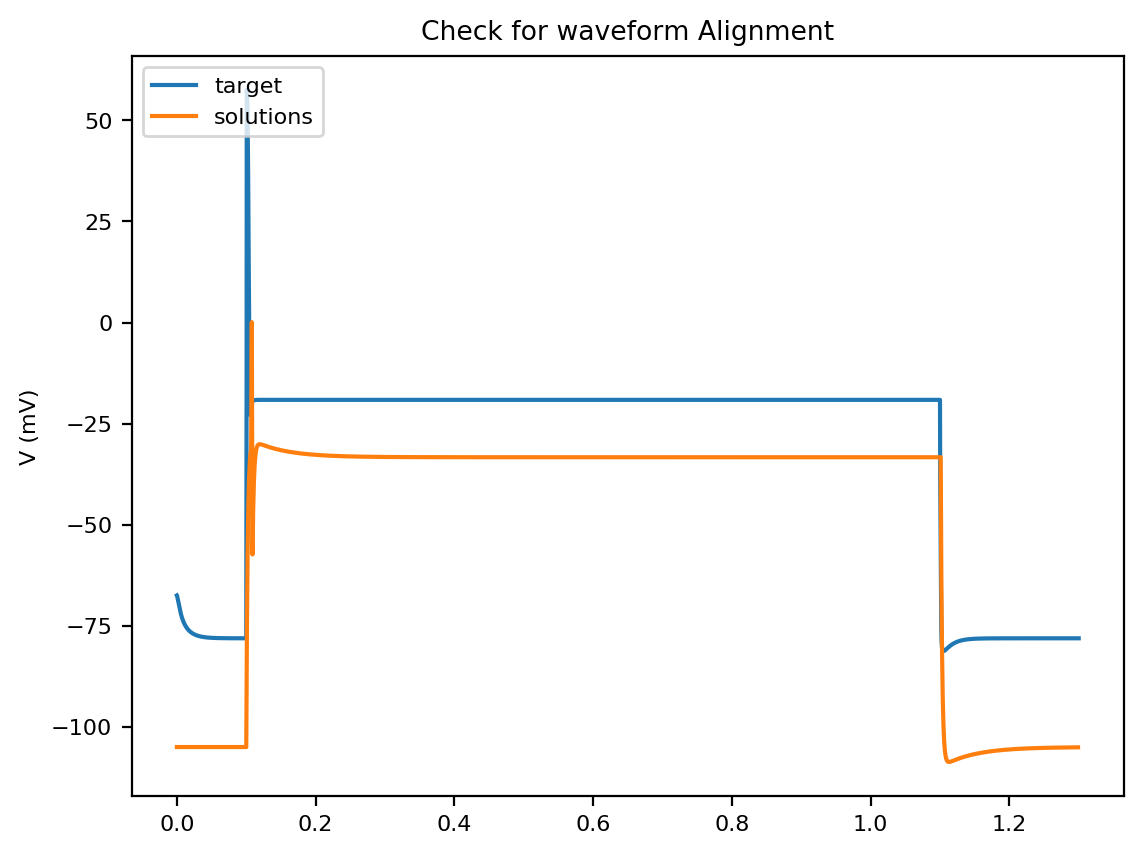

In [35]:
check_binary_match(target,opt,snippets=False)


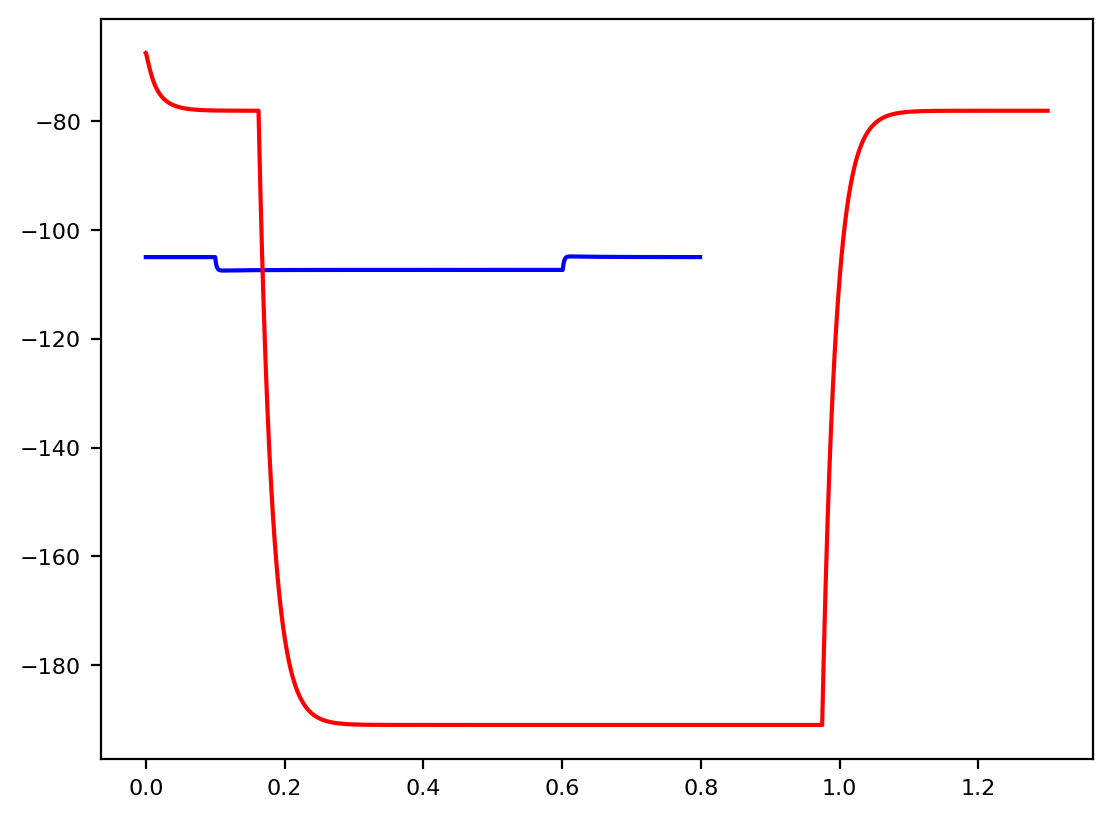

In [38]:
from neuronunit.optimisation.optimization_management import inject_and_plot_passive_model
#inject_and_plot_passive_model(opt)
import quantities as pq
tm = target.dtc_to_model()

model = opt.dtc_to_model()
uc = {'amplitude':-10*pq.pA,'duration':500*pq.ms,'delay':100*pq.ms}
model.inject_square_current(uc)
vm1 = model.get_membrane_potential()
tm.inject_square_current(uc)
vm0 = tm.get_membrane_potential()
plt.plot(vm1.times, vm1.magnitude, c='b',label=str('opt ADEXP'))#+str(model.attrs['a']))
plt.plot(vm0.times, vm0.magnitude, c='r',label=str('target HH'))#+str(model.attrs['a']))

plt.show()

In [54]:
display(pd.DataFrame([{k.name:v for k,v in opt.SA.items()}]))

,RheobaseTest,TimeConstantTest,RestingPotentialTest,InputResistanceTest,CapacitanceTest,InjectedCurrentAPWidthTest,InjectedCurrentAPAmplitudeTest,InjectedCurrentAPThresholdTest
0,1.334155,149.6,10.170472,142.5,7205.0,0.373083,0.312678,0.197246


What where the values of model parameters that where held constant?


In [ ]:
df0 = opt.dtc_to_model().default_attrs
df1 = target.dtc_to_model().default_attrs
hc = {}

try:
    df0.attrs.pop('dt',None)
    df0.attrs.pop('Iext',None)
    opt.attrs.pop('dt',None)
    opt.attrs.pop('Iext',None)

except:
    pass

for k,v in df0.items():
    if k not in opt.attrs.keys():
        assert df0[k] == df1[k]
        hc[k] = v        
display("Held constant:")
display(pd.DataFrame([hc]))        

If the Pareto Front encircles the best solution without sampling directly on top of it.
Does piercing the center get us closer to the hall of fame?
Below, plot HOF[0]/PF[0] are they the same model? 

In [ ]:
# check_binary_match(opt,hof,snippets=True)


# Exploring the neighbourhood of 
the Optimal solution is now syntatically easy

## Make ranges to explore:

In [40]:
from neuronunit.optimisation.model_parameters import MODEL_PARAMS
a_range = MODEL_PARAMS["ADEXP"]['C']
grid_a = np.linspace(a_range[0],a_range[1],10)
b_range = MODEL_PARAMS["ADEXP"]['b']
grid_b = np.linspace(b_range[0],b_range[1],10);



## Mutate a parameter in a dimension of interest.

In [43]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['C'],opt_sum)
from tqdm import tqdm
import copy
collect = []
mutant = copy.copy(opt)
for a in tqdm(grid_a):
    # non random mutation
    mutant.attrs['C'] = a
    # Evaluate NU test suite
    mutant.self_evaluate()
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)

100%|██████████| 10/10 [01:51<00:00, 11.15s/it]


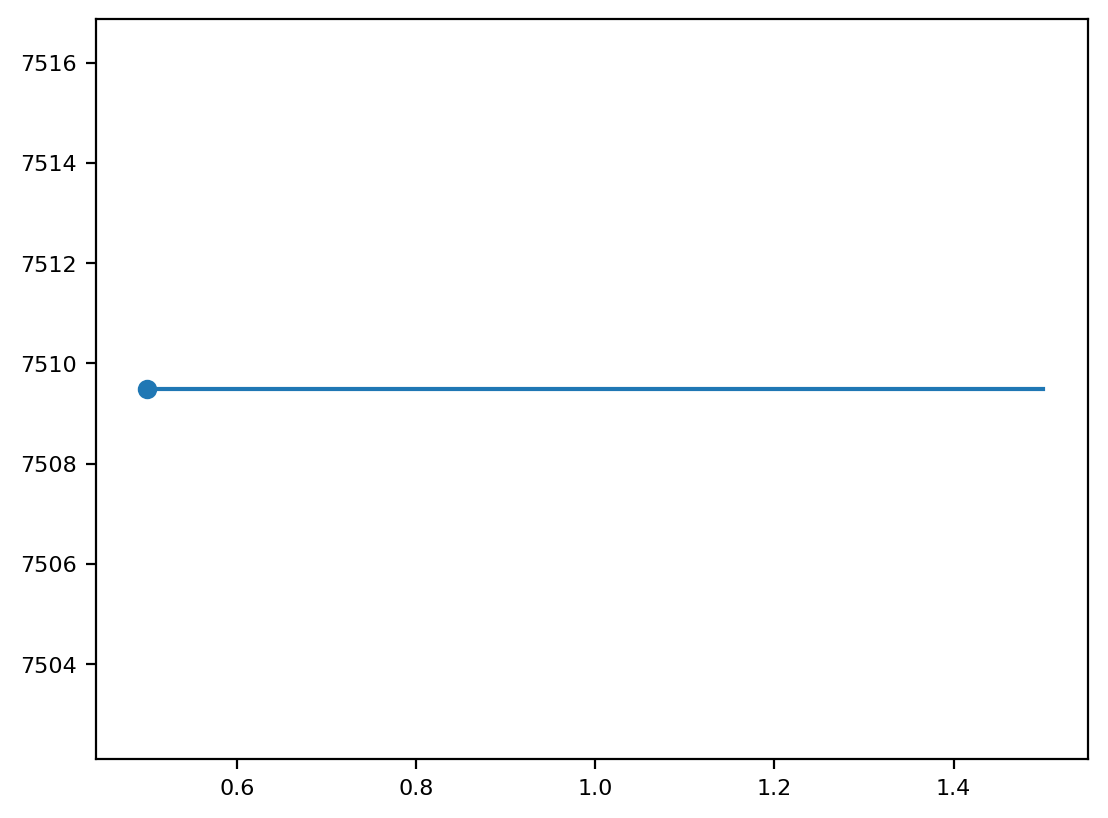

In [44]:
plt.plot(grid_a,collect)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')


The above plot seemed to have two steep wells, of low error about the optima.

It might not be reasonable to expect to sample every such well, as the stochastic nature of the GA is not garunteed to sample small and and focused pockets of error change.

In [50]:
opt_sum = np.sum(opt.SA.values)
for_scatter = (opt.attrs['b'],opt_sum)
from tqdm import tqdm
collect = []
mutant = copy.copy(opt)

#insert_index = find_nearest(grid_b,opt.attrs['b'])[1]
grid_b = list(grid_b)
#grid_b.insert(insert_index,opt.attrs['b'])
crheo = []
for b in tqdm(grid_b):
    # non random mutation
    mutant.attrs['b'] = b
    #print(mutant.attrs)
    # Evaluate NU test suite
    mutant.self_evaluate()
    #print(mutant.rheobase)
    crheo.append(mutant.rheobase)
    # sum components (optional)
    fit = np.sum(mutant.SA.values)
    collect.append(fit)


100%|██████████| 10/10 [01:53<00:00, 11.34s/it]


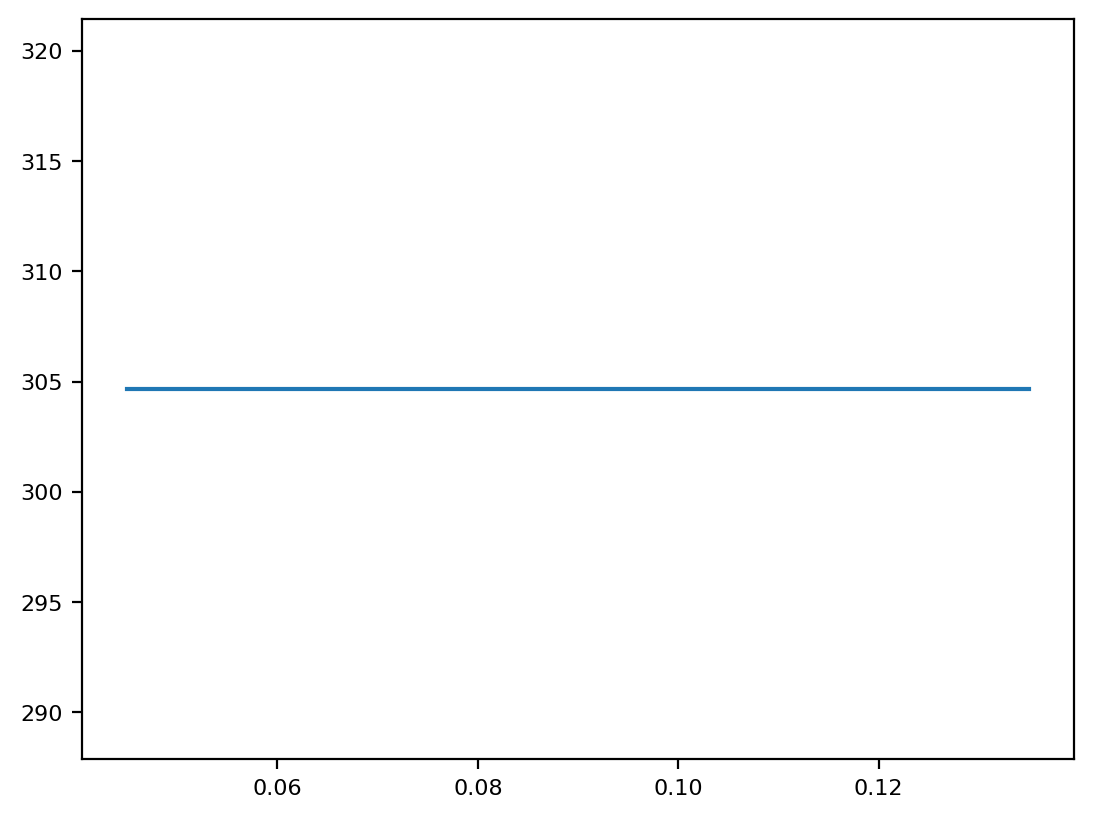

In [48]:
plt.plot(grid_b,crheo)


[0.045, 0.055, 0.065, 0.07500000000000001, 0.085, 0.095, 0.10500000000000001, 0.115, 0.125, 0.135]


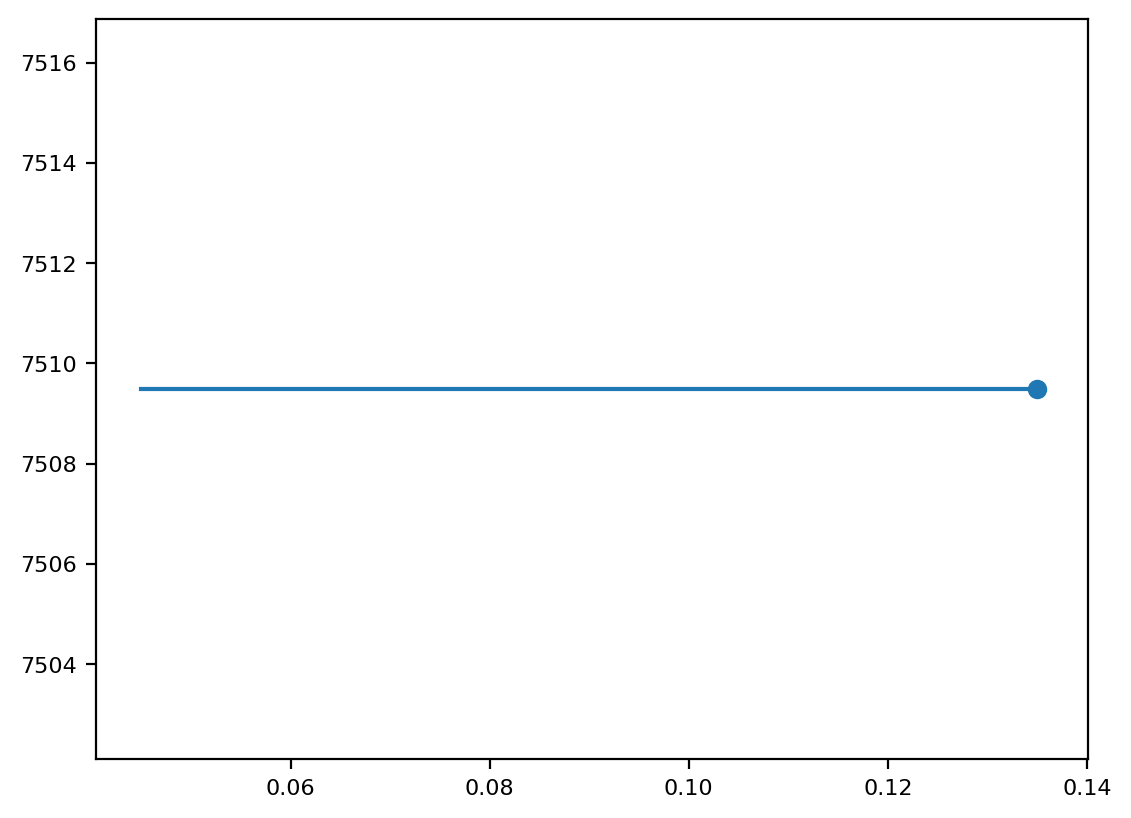

In [49]:
plt.plot(grid_b,collect)
for_scatter = (opt.attrs['b'],opt_sum)
plt.scatter(for_scatter[0],for_scatter[1],label='optima')
print(grid_b)